# Assignment 3

By: Jordan Ponn (996765781) <br>
Course: MIE1513

In [1]:
# import required libraries
import numpy as np
import pandas as pd
from sklearn.metrics.pairwise import pairwise_distances
from heapq import nlargest
from sklearn.metrics import mean_squared_error
from math import sqrt
import os.path
import scipy.stats as st

In [2]:
# define constant for movie lends 100K directory
MOVIELENS_DIR = "/resources/data/ml-100k/"

datasetsFileNames = [('u1.base', 'u1.test'),
                     ('u2.base', 'u2.test'),
                     ('u3.base', 'u3.test'),
                     ('u4.base', 'u4.test'),
                     ('u5.base', 'u5.test')]

## Loading the Data

From Recommender Lab, load movie rating data into notebook

In [3]:
# Load rating data from u.data file
fields = ['userID', 'itemID', 'rating', 'timestamp']
ratingDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.data'), sep='\t', names=fields)

ratingDF.head()

,userID,itemID,rating,timestamp
0,196,242,3,881250949
1,186,302,3,891717742
2,22,377,1,878887116
3,244,51,2,880606923
4,166,346,1,886397596


In [4]:
# Get number of users and movies
numUsers = len(ratingDF.userID.unique())
numItems = len(ratingDF.itemID.unique())

print("Number of users:", numUsers)
print("Number of items:", numItems)

Number of users: 943
Number of items: 1682


In [5]:
# Get movie information
fieldsMovies = ['movieID', 'movieTitle', 'releaseDate', 'videoReleaseDate', 'IMDbURL', 'unknown', 'action', 'adventure',
          'animation', 'childrens', 'comedy', 'crime', 'documentary', 'drama', 'fantasy', 'filmNoir', 'horror',
          'musical', 'mystery', 'romance','sciFi', 'thriller', 'war', 'western']
moviesDF = pd.read_csv(os.path.join(MOVIELENS_DIR, 'u.item'), sep='|', names=fieldsMovies, encoding='latin-1')

moviesDF.head()

,movieID,movieTitle,releaseDate,videoReleaseDate,IMDbURL,unknown,action,adventure,animation,childrens,...,fantasy,filmNoir,horror,musical,mystery,romance,sciFi,thriller,war,western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


## Building User-to-Item Rating Matrix

In [6]:
def buildUserItemMatrix(dataset, numUsers, numItems):
    # Initialize a of size (numUsers, numItems) to zeros
    matrix = np.zeros((numUsers, numItems), dtype=np.int8)
    
    # Populate the matrix based on the dataset
    for (index, userID, itemID, rating, timestamp) in dataset.itertuples():
        matrix[userID-1, itemID-1] = rating
    return matrix

In [7]:
# Load all datasets
trainUsrItmMatrixList = []
testUsrItmMatrixList = []
for trainFileName, testFileName in datasetsFileNames:
    curTrainDF = pd.read_csv(os.path.join(MOVIELENS_DIR, trainFileName), sep='\t', names=fields)
    curTestDF = pd.read_csv(os.path.join(MOVIELENS_DIR, testFileName), sep='\t', names=fields)
    trainUsrItmMatrixList.append(buildUserItemMatrix(curTrainDF, numUsers, numItems))
    testUsrItmMatrixList.append(buildUserItemMatrix(curTestDF, numUsers, numItems))

## Row-Row Similarity

In [8]:
def predictByRowSimilarity(trainSet, numRows, numCols, similarity, showProgress=False):
    # Initialize the predicted rating matrix with zeros
    predictionMatrix = np.zeros((numRows, numCols))
    
    for (row,item), rating in np.ndenumerate(trainSet):
        # Predict rating for every item that wasn't ranked by the user (rating == 0)
        if rating == 0:
            # Extract the users that provided rating for this item
            itemVector = trainSet[:,item]
            rowsRatings = itemVector[itemVector.nonzero()]
            
            # Get the similarity score for each of the users that provided rating for this item
            rowsSim = similarity[row,:][itemVector.nonzero()]
            
            # If there no users that ranked this item, use user's average
            if (len(rowsSim) == 0 or rowsSim.sum() == 0):
                rowVector = trainSet[row, :]
                ratedItems = rowVector[rowVector.nonzero()]
                
                # If the user didnt rated any item use 0, otherwise use average
                if len(ratedItems) == 0:
                    predictionMatrix[row,item] = 0
                else:
                    predictionMatrix[row,item] = ratedItems.mean()
            else:
                # predict score based on user-user similarity
                predictionMatrix[row,item] = (rowsRatings*rowsSim).sum() / rowsSim.sum()
        
        # report progress every 100 users
        if (row % 100 == 0 and item == 1 and showProgress):
            print ("calculated %d rows" % (row,))
    
    return predictionMatrix

## Evalution Functions

In [9]:
def rmse(pred, test):
    # calculate RMSE for all the items in the test dataset
    predItems = pred[test.nonzero()].flatten() 
    testItems = test[test.nonzero()].flatten()
    return sqrt(mean_squared_error(predItems, testItems))

In [10]:
# Calcualte cross validation average and ci% confidence intervals (95% by default)
def avgScoreAndConfidence(scores, ci=0.95):    
    avgScore = np.mean(scores)
    scoreCi = st.t.interval(ci, len(scores)-1, loc=np.mean(scores), scale=st.sem(scores))
    return avgScore, scoreCi

In [11]:
def avgPrecisionAtK(testSet, prediction, k):
    # Initialize sum and count vars for average calculation
    sumPrecisions = 0
    countPrecisions = 0
    
    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
    for userID in range(len(prediction)):
        # Pick top K based on predicted rating
        userVector = prediction[userID,:]
        topK = nlargest(k, range(len(userVector)), userVector.take)
        
        # Convert test set ratings to like / don't like
        userTestVector = vf(testSet[userID,:]).nonzero()[0]
        
        # Calculate precision
        precision = len([item for item in topK if item in userTestVector])/len(topK)
        
        # Update sum and count
        sumPrecisions += precision
        countPrecisions += 1
        
    # Return average P@k
    return sumPrecisions/countPrecisions

In [12]:
def avgRecallAtK(testSet, prediction, k):
    # Initialize sum and count vars for average calculation
    sumRecalls = 0
    countRecalls = 0
    
    # Define function for converting 1-5 rating to 0/1 (like / don't like)
    vf = np.vectorize(lambda x: 1 if x >= 4 else 0)
    
    for userID in range(len(prediction)):
        # Pick top K based on predicted rating
        userVector = prediction[userID,:]
        topK = nlargest(k, range(len(userVector)), userVector.take)
        
        # Convert test set ratings to like / don't like
        userTestVector = vf(testSet[userID,:]).nonzero()[0]
        
        # Ignore user if has no ratings in the test set
        if (len(userTestVector) == 0):
            continue
        
        # Calculate recall
        recall = len([item for item in topK if item in userTestVector])/len(userTestVector)
        
        # Update sum and count
        sumRecalls += recall
        countRecalls += 1
    
    # Return average R@k
    return sumRecalls/countRecalls

In [13]:
def kFoldPerformanceEvaluation(rmseList, pAtKList, rAtKList):
    ci = 0.95
    
    # Evaluate confidence interval ci% over k-folds
    rmseAvg, rmseInt = avgScoreAndConfidence(rmseList, ci)
    pAtKAvg, pAtKInt = avgScoreAndConfidence(pAtKList, ci)
    rAtKAvg, rAtKInt = avgScoreAndConfidence(rAtKList, ci)
    
    # Print results to the console
    print("The average RMSE is {0} with a {2}% confidence interval of {1}".format(rmseAvg, rmseInt, round(ci*100)))
    print("The average P@{2} is {0} with a {3}% confidence interval of {1}".format(pAtKAvg, pAtKInt, atK, round(ci*100)))
    print("The average R@{2} is {0} with a {3}% confidence interval of {1}".format(rAtKAvg, rAtKInt, atK, round(ci*100)))

## Making Recommendations

In [14]:
def userTopK(prediction, moviesDataset, userID, k):
    # Pick top K based on predicted rating
    userVector = prediction[userID+1,:]
    topK = nlargest(k, range(len(userVector)), userVector.take)
    namesTopK = list(map(lambda x: moviesDataset[moviesDataset.movieID == x+1]["movieTitle"].values[0], topK))
    return namesTopK

## Assignment Questions

In [15]:
# Constants
atK = 10 # for P@k and R@k

### Q1.) Similarity in User-User Collaborative Filtering

In [16]:
def kFoldUserSimilarity (trainList, testList, simMetric):
    rmseList = []
    pAtKList = []
    rAtKList= []   

    # Predict each training set
    for i, (train, test) in enumerate(zip(trainList, testList)):
        
        # Evaluate similarity matrix
        rowSimilarity = []
        if (simMetric == 'cosine'):
            rowSimilarity = 1 - pairwise_distances(train, metric='cosine')
        else:
            rowSimilarity = 1/pairwise_distances(train, metric=simMetric)
        
        # Predict ratings with User-User similarity
        userSimPrediction = predictByRowSimilarity(train, len(train), numItems, rowSimilarity)
        
        # Evaluate performance metrics RMSE, P@K and R@K
        rmseList.append(rmse(userSimPrediction, test))
        pAtKList.append(avgPrecisionAtK(test, userSimPrediction, atK))
        rAtKList.append(avgRecallAtK(test, userSimPrediction, atK))
    
    # Evaluate confidence interval over k-folds
    kFoldPerformanceEvaluation(rmseList, pAtKList, rAtKList)

In [17]:
kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList, 'cosine')

The average RMSE is 1.0173541216605808 with a 95% confidence interval of (1.0090130802261479, 1.0256951630950137)
The average P@10 is 0.0004453870625662779 with a 95% confidence interval of (0.00019211151769883521, 0.00069866260743372058)
The average R@10 is 0.00032082672136588865 with a 95% confidence interval of (0.00014991646224179681, 0.00049173698048998044)


In [18]:
kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList, 'euclidean')

The average RMSE is 1.0224858934767425 with a 95% confidence interval of (1.0136930548285885, 1.0312787321248964)
The average P@10 is 0.0003817603393425239 with a 95% confidence interval of (0.0002316315188778076, 0.00053188915980724016)
The average R@10 is 0.00026546144717910417 with a 95% confidence interval of (0.0001508308841757179, 0.00038009201018249044)


In [19]:
kFoldUserSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList, 'manhattan')

The average RMSE is 1.0223993230374169 with a 95% confidence interval of (1.0135310622628049, 1.0312675838120289)
The average P@10 is 0.00033934252386002124 with a 95% confidence interval of (0.0001951034187363188, 0.00048358162898372368)
The average R@10 is 0.0002487234892099764 with a 95% confidence interval of (0.00014374835396953561, 0.00035369862445041721)


The cosine similarity metric works better than the euclidian metric.  This is because euclidian is not normalizing the vectors to account for strength preference (i.e. two users mave have similar tastes, but one may tend to have inflated ratings). The manhattan metric performs worse than euclidian as it is also a distance metric, but uses strictly horizontal or vertical paths instead of the direct path between the two vectors.

### Q2.) Item-Item Collaborative Filtering

In [20]:
def predictByItemSimilarity(trainSet, numUsers, numItems, similarity):
    return predictByRowSimilarity(trainSet, numItems, numUsers, similarity)

def kFoldItemSimilarity(trainList, testList, returnResult = False):
    rmseList = []
    pAtKList = []
    rAtKList= []
    bestPred = []
    trainIndex = 0
    
    for i, (train, test) in enumerate(zip(trainList, testList)):
        users = len(train)
        # Transpose user-item matrix
        trainTrans = np.transpose(train)
        
        # Evaluate similarity matrix
        sim = 1 - pairwise_distances(trainTrans, metric='cosine')
        
        # Perform similarity analysis where Items are now rows
        userSimPrediction = np.transpose(predictByItemSimilarity(trainTrans, users, numItems, sim))
        
        # Keep best prediction matrix based on RMSE
        err = rmse(userSimPrediction, test)
        if (len(rmseList) == 0 or err < min(rmseList)):
            bestPred = userSimPrediction
            trainIndex = i
        
        # Evaluate performance metrics RMSE, P@K and R@K
        rmseList.append(err)
        pAtKList.append(avgPrecisionAtK(test, userSimPrediction, atK))
        rAtKList.append(avgRecallAtK(test, userSimPrediction, atK))
        
    # Evaluate confidence interval over k-folds
    kFoldPerformanceEvaluation(rmseList, pAtKList, rAtKList)
    
    # Return best prediction matrix and index of training set used of requested
    if(returnResult):
        return bestPred, trainIndex

In [21]:
itemSimPred, bestItemTrainIndex = kFoldItemSimilarity(trainUsrItmMatrixList, testUsrItmMatrixList, returnResult = True)

The average RMSE is 1.0200829001062477 with a 95% confidence interval of (1.006824268625073, 1.0333415315874224)
The average P@10 is 0.00012725344644750795 with a 95% confidence interval of (6.8368078362719003e-05, 0.00018613881453229689)
The average R@10 is 0.00012026885276058383 with a 95% confidence interval of (4.0408614452877342e-05, 0.00020012909106829034)


b.) See above for the RMSE results.  The User-user similarity model performed slightly better than Item-item model.  This is because there are significantly more items than users in each data set (1682 Items and 943 Users), so there is likely more data per user than per item.

### Q3.) Performance Comparison

a.) See output above for RMSE, P@k, and R@k for all recommenders. k was selected to be 10, as most user interfacing systems offer 'top-10' lists.  This gives enough options without overwhelming the user.

b.) With the baselines where user average was used for for all predictions, P@K and R@K would be meaningless as you cannot rank items if they all have the same value.  With the baseline using popularity, RMSE would be useless as this methods aims to rank items relative to eachother and ignores the actual rank itself, which will cause an inflated RMSE.

c.) In each metric, User-user outperforms item-item in each case.  Again, this is due to the bias in the data favoring the user-user approach, as mentioned in answer 2b.

d.) Performance in one metric does not imply performance in the other, as they are evaluating different things.  RMSE evaluates how well the rating was predicted, while P@K and R@K evalutes how items rank relative to eachother, based on a specific context.

### Q4.) Similarity Evaluation

In [22]:
# Search dataset by title field for Movie ID and Movie Title
def getMovieIDs(moviesDataset, query):
    resultDF = pd.DataFrame(moviesDataset["movieTitle"].str.contains(query))
    movieIDs = [index+1 for index, value in resultDF.itertuples() if (value)]
    return [[movieID, movieTitle] for movieID, movieTitle in zip(movieIDs, getMovieList(moviesDF, movieIDs))]

# Get movie list titles based on IDs
def getMovieList(moviesDataset, idList):
    names = list(map(lambda x: moviesDataset[moviesDataset.movieID == x]["movieTitle"].values[0], idList))
    return names

# Find top k similar movies based on a simularity matrix
def kSimilarMovies(movieDataset, movieSim, movieID, k):
    print("Top {0} movies for movie: {1}".format(k, getMovieList(movieDataset,[movieID])[0]))
    return getMovieList(movieDataset, [x+1 for x in np.argsort(movieSim[movieID-1])[0:k]])

# Merge train and predictions to get more information for similarity comparison
def mergePredictAndTrain(train, prediction):
    # Initialize the merged rating matrix with zeros
    mergeMatrix = np.zeros((numUsers, numItems))
    
    # Merge the two matricies together
    for (row,item), rating in np.ndenumerate(train):
        if rating == 0:
            mergeMatrix[row,item] = prediction[row,item]
        else:
            mergeMatrix[row,item] = train[row,item]
    return mergeMatrix

In [23]:
# Search Movie DB for movies based on title
getMovieIDs(moviesDF, "Ghost")

[[148, 'Ghost and the Darkness, The (1996)'],
 [402, 'Ghost (1990)'],
 [1050, 'Ghost and Mrs. Muir, The (1947)'],
 [1136, 'Ghosts of Mississippi (1996)'],
 [1240, 'Ghost in the Shell (Kokaku kidotai) (1995)']]

In [24]:
# Constants
topKMovies = 5
movieID1 = 173 # Princess Bride, The (1987)
movieID2 = 1240 # Ghost in the Shell (Kokaku kidotai) (1995)
movieID3 = 24 # Rumble in the Bronx (1995)

In [25]:
# Create Item Similarity Matrix with merged train and prediction matrix
movieSim = 1 - pairwise_distances(np.transpose(mergePredictAndTrain(trainUsrItmMatrixList[bestItemTrainIndex], itemSimPred)), metric='cosine')

In [26]:
kSimilarMovies(moviesDF, movieSim, movieID1, topKMovies)

Top 5 movies for movie: Princess Bride, The (1987)


['Lady of Burlesque (1943)',
 'King of New York (1990)',
 'Savage Nights (Nuits fauves, Les) (1992)',
 'MURDER and murder (1996)',
 'Butterfly Kiss (1995)']

In [27]:
kSimilarMovies(moviesDF, movieSim, movieID2, topKMovies)

Top 5 movies for movie: Ghost in the Shell (Kokaku kidotai) (1995)


['Small Faces (1995)',
 'Target (1995)',
 'Favor, The (1994)',
 'Chairman of the Board (1998)',
 'Entertaining Angels: The Dorothy Day Story (1996)']

In [28]:
kSimilarMovies(moviesDF, movieSim, movieID3, topKMovies)

Top 5 movies for movie: Rumble in the Bronx (1995)


['Gate of Heavenly Peace, The (1995)',
 'New Age, The (1994)',
 'Favor, The (1994)',
 'Chairman of the Board (1998)',
 'Entertaining Angels: The Dorothy Day Story (1996)']

b.) The recommendations made moderate amounts of sense.  As mentioned earlier, given that the data is biased towards users who have rated both items, the inaccuracies in the similarity matrix stem from lack of ratings for each movie, meaning the prediction matrix needs to resort to using averages.  As seen above, the reccomender can only give broad suggestions for movies with fewer rating.

### Q5.) Testing with different user types

In [29]:
# Count number of user ratings across all users
def getUserRatingCounts(userItemMatrix):
    return [np.size(userRatings.nonzero()) for userRatings in userItemMatrix]
#return [np.size(np.where(userRatings>0)) for userRatings in userItemMatrix]

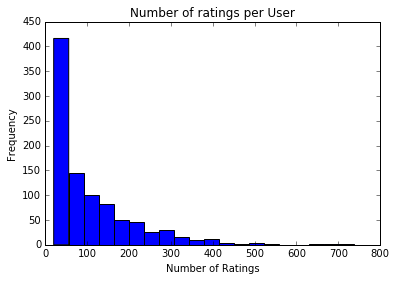

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline

# Get ratings per user across all users
allUserRatingCounts = getUserRatingCounts(buildUserItemMatrix(ratingDF, numUsers, numItems))

# Plot histogram
ax = plt.subplot(111)
plt.hist(allUserRatingCounts, bins=20)
plt.title("Number of ratings per User")
ax.set_ylabel('Frequency')
ax.set_xlabel('Number of Ratings')
plt.show()

In [31]:
trainAboveThresholdList = []
testAboveThresholdList =[]
trainBelowThresholdList = []
testBelowThresholdList =[]

# Define threshold
threshold = np.mean(allUserRatingCounts)

for train, test in zip(trainUsrItmMatrixList, testUsrItmMatrixList):
    # Calculate number of ratings per user
    userRatingCounts = getUserRatingCounts(train)
    
    # Find all user IDs of users above the threshold value
    aboveThresholdIDList = [userID for userID, ratingCount in enumerate(userRatingCounts) if ratingCount> threshold]
    belowThresholdIDList = [x for x in range(0,numUsers) if x not in aboveThresholdIDList]
    
    # Slice test and train sets based on threshold value
    trainAboveThresholdList.append(train[aboveThresholdIDList])
    testAboveThresholdList.append(test[aboveThresholdIDList])
    trainBelowThresholdList.append(train[belowThresholdIDList])
    testBelowThresholdList.append(test[belowThresholdIDList])

In [32]:
kFoldUserSimilarity(trainAboveThresholdList, testAboveThresholdList, 'cosine')

The average RMSE is 1.010974265942393 with a 95% confidence interval of (0.99176128080106618, 1.03018725108372)
The average P@10 is 0.0016390480305763272 with a 95% confidence interval of (-0.0011795544535935718, 0.0044576505147462262)
The average R@10 is 0.0008867660718454142 with a 95% confidence interval of (-0.00063443178595909205, 0.0024079639296499204)


In [33]:
kFoldUserSimilarity(trainBelowThresholdList, testBelowThresholdList, 'cosine')

The average RMSE is 1.0470728344203217 with a 95% confidence interval of (1.0411611200780206, 1.0529845487626228)
The average P@10 is 0.0006520323741540288 with a 95% confidence interval of (0.00022604562723096998, 0.0010780191210770875)
The average R@10 is 0.0005866409905939891 with a 95% confidence interval of (-5.2874099783176576e-06, 0.0011785693911662959)


In [34]:
kFoldItemSimilarity(trainAboveThresholdList, testAboveThresholdList)

The average RMSE is 1.0195239100839637 with a 95% confidence interval of (1.002380352537233, 1.0366674676306944)
The average P@10 is 0.0010462215881791074 with a 95% confidence interval of (0.00066416276786537549, 0.0014282804084928393)
The average R@10 is 0.0005485045129872966 with a 95% confidence interval of (6.3679874725235358e-05, 0.001033329151249358)


In [35]:
kFoldItemSimilarity(trainBelowThresholdList, testBelowThresholdList)

The average RMSE is 1.0569827867576653 with a 95% confidence interval of (1.0415787563320638, 1.0723868171832669)
The average P@10 is 0.0001775162189782358 with a 95% confidence interval of (9.5978500860809853e-05, 0.00025905393709566178)
The average R@10 is 0.00010638322288681415 with a 95% confidence interval of (4.5350476503817081e-05, 0.00016741596926981122)


In all cases, the dataset looking at above the threshold had improved results for each metric, while the dataset below the threshold had worse results.  This is because removing the low threshold items improved the overall quality of the dataset, as there was more information to draw on to determine fewer predictions.  Conversly, the low threshold set performed worst as there was less data available for more predictions.